# Finite State Machine
* To download notebook to this tutorial, see [here](https://github.com/defipy-devs/defipy-docs/blob/main/docs/tutorials/fsm.ipynb) 

In [1]:
from defipy import *
import numpy as np
import datetime
import matplotlib.pyplot as plt

<img src="../img/state_machine.png" alt="Alt Text" width="400"/>

Useful for when we want to factor in the supply of mintable/burnable token in a simulated DEX environment; typically, there are four states to consider in these types of situations, as per figure above, which are as follows:
* mint
* hold
* in-use (LP)
* burn

In [2]:
import numpy as np
import pandas as pd
from termcolor import colored

class TokenState():
    
    def __init__(self, stochastic = True, tDel = None):
        self.tDel = TokenDeltaModel(500) if tDel == None else tDel
        self.stochastic = stochastic
        self.current_state = [[0, 0, 0, 0]]
        self.states = self.current_state

    def gen_states(self, N):   
        for k in range(N):
            self.next_state(self.tDel.delta())
        return self.get_state_df()          
        
    def next_state(self, minted = None):
        P = self.gen_trans_matrix(self.stochastic)     
        self.current_state = np.dot(self.current_state, P)
        minted = self.tDel.delta() if minted == None else minted
        self.current_state = self.current_state  + np.array([[minted, 0.0, 0.0, 0.0]])
        self.states = np.append(self.states, self.current_state, axis=0)
        
    def update_current_state(self, amt, stat_cat = 'LP'):
        if(stat_cat == 'LP'):
            self.states[-1,1] += amt  # Add to held
            self.states[-1,2] -= amt  # Remove from vault
             
    def get_current_state(self, colnm = None):  
        df_states = self.get_state_df(self.states[-2:])
        return df_states.iloc[-1] if colnm == None else df_states[colnm].iloc[-1]
    
    def get_state_df(self, state_arr = []): 
        state_arr = self.states[1:,] if len(state_arr) == 0 else state_arr
        df_states = pd.DataFrame(self.states[1:,])    
        df_states.columns = ['Mint', 'Held', 'LP', 'Burn'] 
        df_states['dHeld'] = np.insert(np.diff(df_states['Held'].values), 0, 0)
        df_states['dLP'] = np.insert(np.diff(df_states['LP'].values), 0, 0)
        df_states['dBurn'] = np.insert(np.diff(df_states['Burn'].values), 0, 0) 
        return df_states
        
    def scale_x(self, x):
        return list(x/np.sum(x))
    
    def rBeta(self, a, b, mx = None, mn =None):
        p = np.random.beta(a,b)
        p = p if mn == None else max(p, mn)
        p = p if mx == None else min(p, mx)                  
        return p   

    def gen_trans_matrix(self, stochastic = True):

        P_stochastic = np.array([ [0, 1, 0, 0],
                           [0, self.rBeta(19,81), self.rBeta(4,1), self.rBeta(1,99)],
                           [0, self.rBeta(1,4, mn = 0.2, mx = 0.3), self.rBeta(4,1, mn = 0.7, mx = 0.8), 0],
                           [0, 0, 0, 1]])

        P_deterministic = np.array([ [0, 1, 0, 0],
                           [0, 0.18, 0.8, 0.02],
                           [0, 0.2, 0.8, 0],
                           [0, 0, 0, 1]])    

        P = P_stochastic if stochastic else P_deterministic  
        return np.array(list(map(self.scale_x, P))) 
    
    def inspect_states(self, tail = True, num_states = 5):
        dfDistrLP1 = self.get_state_df()
        return dfDistrLP1.tail(num_states) if tail else dfDistrLP1.head(num_states)  

    def check_states(self):
        dfDistrLP = self.get_state_df()
        states_balanced = round(sum(dfDistrLP.iloc[-1,1:4]),8) == round(sum(dfDistrLP.iloc[:-1,0]),8)
        test_outcome = colored('PASS', 'green', attrs=['bold']) if states_balanced else colored('FAIL', 'red', attrs=['bold'])            
        print(f'Amount of tokens retained across states: {test_outcome}')   

### Simulate GBM process

In [3]:
# Instantiation Parameters
n_steps = 500     # Number of steps 
start_price = 10 # Initial price SYS/USD
mu = 0.1; sigma = 0.5
n_paths = 1      # Number of simulationed paths
seconds_year = 31536000

# Brownian Model 
bm = BrownianModel(start_price)
p_arr = bm.gen_gbms(mu, sigma, n_steps-1, n_paths).flatten()

dt = datetime.timedelta(seconds=seconds_year/n_steps)
dates = [datetime.datetime.strptime("2024-09-01", '%Y-%m-%d') + k*dt for k in range(n_steps)]

### Setup UniV2 Pool

In [4]:
user_nm = 'user0'
finite_tkn_amt = 1000
market_tkn_amt = p_arr[0]*finite_tkn_amt

ftkn_nm = 'FTKN'
mtkn_nm = 'MTKN'

lp_state = TokenState(stochastic = True)
TKN_amt = TokenDeltaModel(100)

finite_tkn = ERC20(ftkn_nm, "0x111")
market_tkn = ERC20(mtkn_nm, "0x09")
exchg_data = UniswapExchangeData(tkn0 = finite_tkn, tkn1 = market_tkn, symbol="LP", address="0x011")

factory = UniswapFactory("pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, finite_tkn_amt, market_tkn_amt)

lp.summary()

Exchange FTKN-MTKN (LP)
Reserves: FTKN = 1000.0, MTKN = 10000.0
Liquidity: 3162.2776601683795 



### Simulation: Random Swapping + Token Supply

In [5]:
arb = CorrectReserves(lp, x0 = p_arr[0])
mint_finite_tkn_deposit = TKN_amt.delta()
lp_state.next_state(mint_finite_tkn_deposit) 

pFTKN_MTKN_arr = []; 

for k in range(n_steps):

    # *****************************
    # ***** Token Supply ******
    # *****************************
    mint_finite_tkn_deposit = TKN_amt.delta()
    lp_state.next_state(mint_finite_tkn_deposit) 
    lp_diff_amt = lp_state.get_current_state('dLP')  

    if(lp_diff_amt > 0):
        AddLiquidity().apply(lp, finite_tkn, user_nm, lp_diff_amt)        
    elif(lp_diff_amt < 0):
        RemoveLiquidity().apply(lp, finite_tkn, user_nm, abs(lp_diff_amt))  
    
    # *****************************
    # ***** Random Swapping ******
    # *****************************
    Swap().apply(lp, finite_tkn, user_nm, TKN_amt.delta())
    Swap().apply(lp, market_tkn, user_nm, p_arr[k]*TKN_amt.delta())
    
    # *****************************
    # ***** Rebalance ******
    # *****************************
    arb.apply(p_arr[k])

    # *****************************
    # ******* Data Capture ********
    # *****************************
    pFTKN_MTKN_arr.append(LPQuote().get_price(lp, finite_tkn))

lp.summary()

Exchange FTKN-MTKN (LP)
Reserves: FTKN = 6598.691296789867, MTKN = 63776.91280880583
Liquidity: 20158.66942286726 



In [6]:
lp_state.check_states()
lp_state.inspect_states(tail = True, num_states = 5)

Amount of tokens retained across states: PASS


,Mint,Held,LP,Burn,dHeld,dLP,dBurn
496,0.813804,1356.778473,4867.921848,3943.407200,-378.681855,371.177034,10.009592
497,16.960313,1568.435538,4655.733806,3944.751981,211.657065,-212.188043,1.344781
498,23.209319,1202.903295,5011.126549,3971.851793,-365.532243,355.392743,27.099812
499,14.570480,1280.700284,4952.715929,3975.674743,77.796989,-58.410620,3.822950
500,33.623355,1249.738985,4965.214933,4008.707518,-30.961299,12.499004,33.032775


### Plot Results

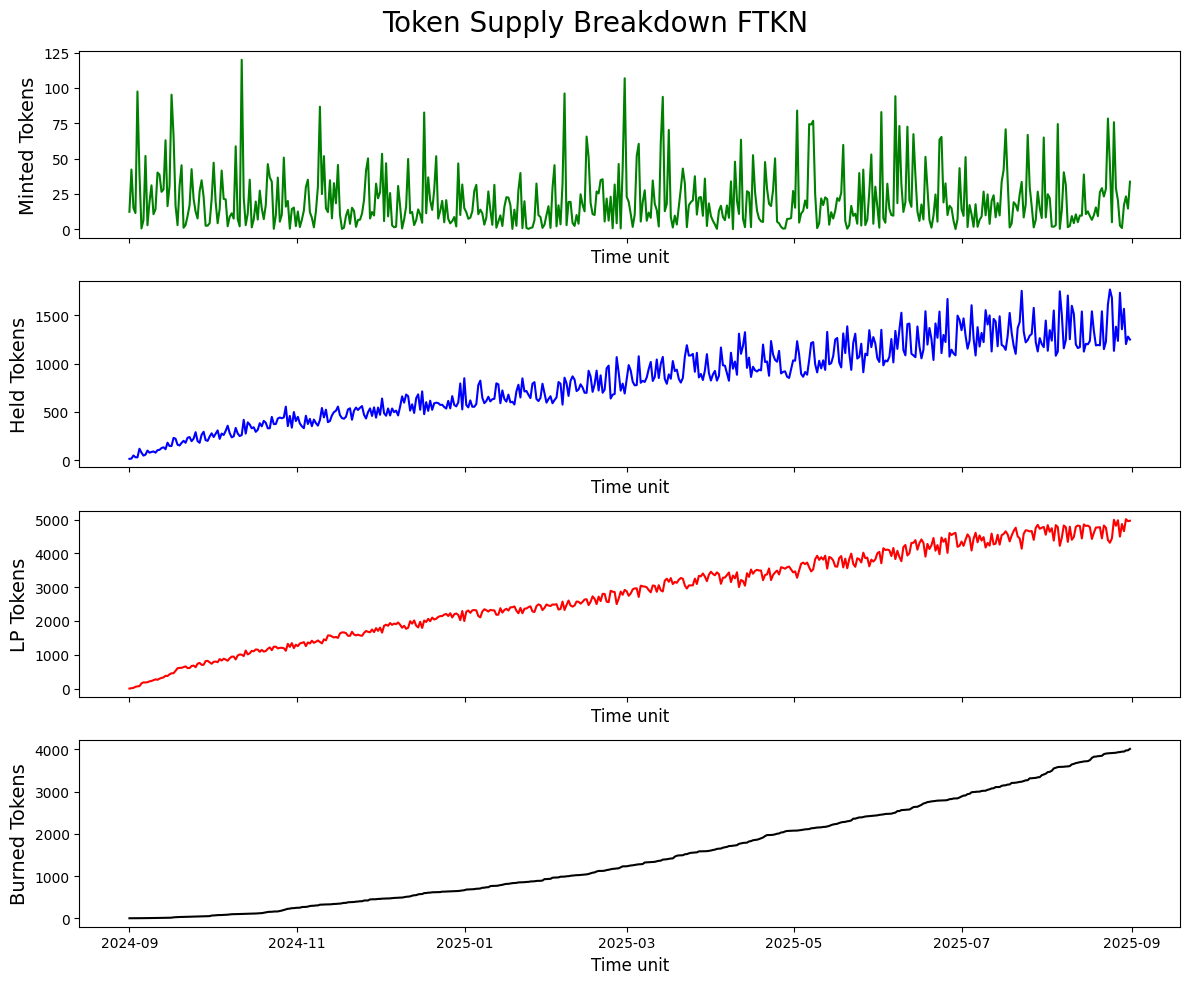

In [7]:
dfDistrLP = lp_state.get_state_df()

mint = dfDistrLP.Mint.values
held = dfDistrLP.Held.values
lpool = dfDistrLP.LP.values
burned = dfDistrLP.Burn.values

fig, (mint_ax, hold_ax, lp_ax, burn_ax) = plt.subplots(nrows=4, sharex=True, sharey=False, figsize=(12, 10))
fig.suptitle(f'Token Supply Breakdown {ftkn_nm}', fontsize=20)
mint_ax.plot(dates, mint[1:], color = 'g', label = 'mint') 
mint_ax.set_xlabel("Time unit", fontsize=12)
mint_ax.set_ylabel("Minted Tokens", fontsize=14)  

hold_ax.plot(dates, held[1:], color = 'blue', label = 'hold') 
hold_ax.set_xlabel("Time unit", fontsize=12)
hold_ax.set_ylabel("Held Tokens", fontsize=14)    

lp_ax.plot(dates, lpool[1:], color = 'r', label = 'lp') 
lp_ax.set_xlabel("Time unit", fontsize=12)
lp_ax.set_ylabel("LP Tokens", fontsize=14)

burn_ax.plot(dates, burned[1:], color = 'black', label = 'burned') 
burn_ax.set_xlabel("Time unit", fontsize=12)
burn_ax.set_ylabel("Burned Tokens", fontsize=14)
plt.tight_layout()

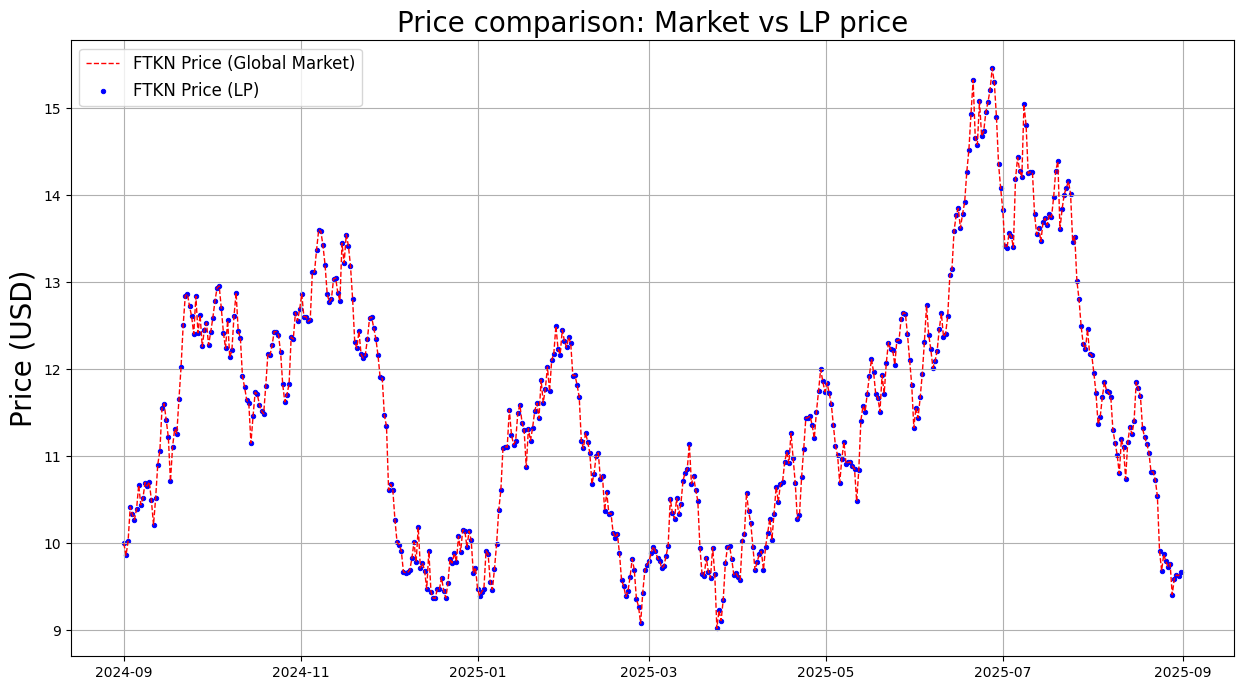

In [8]:
fig, (TKN_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(15, 8))

TKN_ax.plot(dates, p_arr, color = 'r',linestyle = 'dashed', linewidth=1, label=f'{ftkn_nm} Price (Global Market)')
TKN_ax.scatter(dates, pFTKN_MTKN_arr, s=10, marker='o', color = 'b',linestyle = '-', linewidth=0.7, label=f'{ftkn_nm} Price (LP)')

TKN_ax.set_title('Price comparison: Market vs LP price', fontsize=20)
TKN_ax.set_ylabel('Price (USD)', size=20)
TKN_ax.legend(fontsize=12)
TKN_ax.grid()